In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

# Simulation Setup
Simulation of a microring resonator demultiplexer / filter. 
Consists of a ring resonator in the center, a bottom waveguide containing a mode source and the through port, and a top waveguide containing the drop port.

In [15]:
# ring resonator device parameters
wg_height = 0.220 # height of the waveguide (um)
wg_width = 0.480 # width of the waveguide (um)
radius = 2.02 # radius of the ring resonator (um)
gap = 0.140 # gap between the ring resonator and the straight waveguides (um)

In [16]:
# permittivity of the waveguide and substrate at 1550nm
si_eps = 12.085
sio2_eps = 2.0852

# wavelength (in um) and frequency (in Hz)
lambda_range = (1.53, 1.565) # corresponding to the C-band (1.53 to 1.565)
lambda0 = np.sum(lambda_range)/2
freq_range = (td.C_0 / lambda_range[1], td.C_0 / lambda_range[0])
freq0 = td.C_0 / lambda0
freqw = freq_range[1] - freq_range[0]

# frequencies and wavelengths of monitor
Nfreq = 2000
monitor_lambdas = np.linspace(lambda_range[0], lambda_range[1], Nfreq)
monitor_freqs = np.linspace(freq_range[0], freq_range[1], Nfreq)

# spacing between the waveguide and the PML
spacing = 0.8 #um

# simulation domain and total run time
sim_size = (2*(radius + wg_width/2 + spacing), 2*(radius + wg_width/2 + gap + wg_width + spacing), wg_height + 2*spacing)
run_time = 10500/freq0
print("Run Time =", run_time)

# grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl = 20, wavelength = lambda0)

# waveguide, substrate, and air material
mat_wg = td.Medium(
    permittivity = si_eps,
    name = "silicon",
)
mat_substrate = td.Medium(
    permittivity = sio2_eps,
    name = "silica",
)

# ring resonator
ring_outer = td.Structure(
    geometry = td.Cylinder(
        radius = radius + wg_width/2,
        length = wg_height,
    ),
    medium = mat_wg,
    name = "Outer Ring",
)
ring_inner = td.Structure(
    geometry = td.Cylinder(
        radius = radius - wg_width/2,
        length = wg_height,
    ),
    medium = mat_substrate,
    name = "Inner Ring",
)

# top and bottom waveguides
waveguide_top = td.Structure(
    geometry = td.Box(
        center = [0, sim_size[1]/2 - spacing - wg_width/2, 0],
        size = [td.inf, wg_width, wg_height],
    ),
    medium = mat_wg,
    name = "Top Waveguide"
)
waveguide_bottom = td.Structure(
    geometry = td.Box(
        center = [0, -sim_size[1]/2 + spacing + wg_width/2, 0],
        size = [td.inf, wg_width, wg_height],
    ),
    medium = mat_wg,
    name = "Bottom Waveguide"
)

# xy-plane frequency-domain field monitor at central frequency
field_mnt = td.FieldMonitor(
    center = [0,0,0],
    size = [np.inf, np.inf, 0],
    freqs = [td.C_0/1.538433691],
    name = "Field",
)

# through port flux monitor
flux_mnt_through = td.FluxMonitor(
    center = [sim_size[0]/2 - spacing, -(radius + gap + wg_width), 0],
    size = [0, 4 * wg_width, 6 * wg_height],
    freqs = monitor_freqs,
    name = "Flux Monitor (Through Port)"
)

# drop port flux monitor
flux_mnt_drop = td.FluxMonitor(
    center = [-sim_size[0]/2 + spacing, radius + gap + wg_width, 0],
    size = [0, 4 * wg_width, 6 * wg_height],
    freqs = monitor_freqs,
    name = "Flux Monitor (Drop Port)",
    normal_dir = "-"
)

# simulation
sim = td.Simulation(
    size = sim_size,
    grid_spec = grid_spec,
    symmetry = [0, 0, 1],
    structures = [ring_outer, ring_inner, waveguide_top, waveguide_bottom],
    medium = mat_substrate,
    sources = [],
    monitors = [flux_mnt_through, flux_mnt_drop],
    run_time = run_time,
    shutoff = 1e-7,
    boundary_spec = td.BoundarySpec.all_sides(boundary = td.PML())
)


Run Time = 5.419999591850973e-11


# Source Setup
Define a mode source that launches the TE0 mode into the input waveguide.

In [17]:
# position and size of source plane
source_plane = td.Box(
    center = (-sim_size[0]/2 + spacing, -(radius + gap + wg_width), 0),
    size = (0,  4 * wg_width, 6 * wg_height)
)

# number of modes to solve
num_modes = 1

# setup and solve for modes
mode_spec = td.ModeSpec(num_modes = num_modes, group_index_step = True, target_neff = 3.48, filter_pol = 'te')
ms = ModeSolver(simulation = sim, plane = source_plane, mode_spec = mode_spec, freqs = [freq0])
mode_data = ms.solve()

print("Effective index of computed modes: ", np.array(mode_data.n_eff))
print("Group index of computed modes: ", np.array(mode_data.n_group))

Effective index of computed modes:  [[2.49083185]]
Group index of computed modes:  [[4.10919333]]


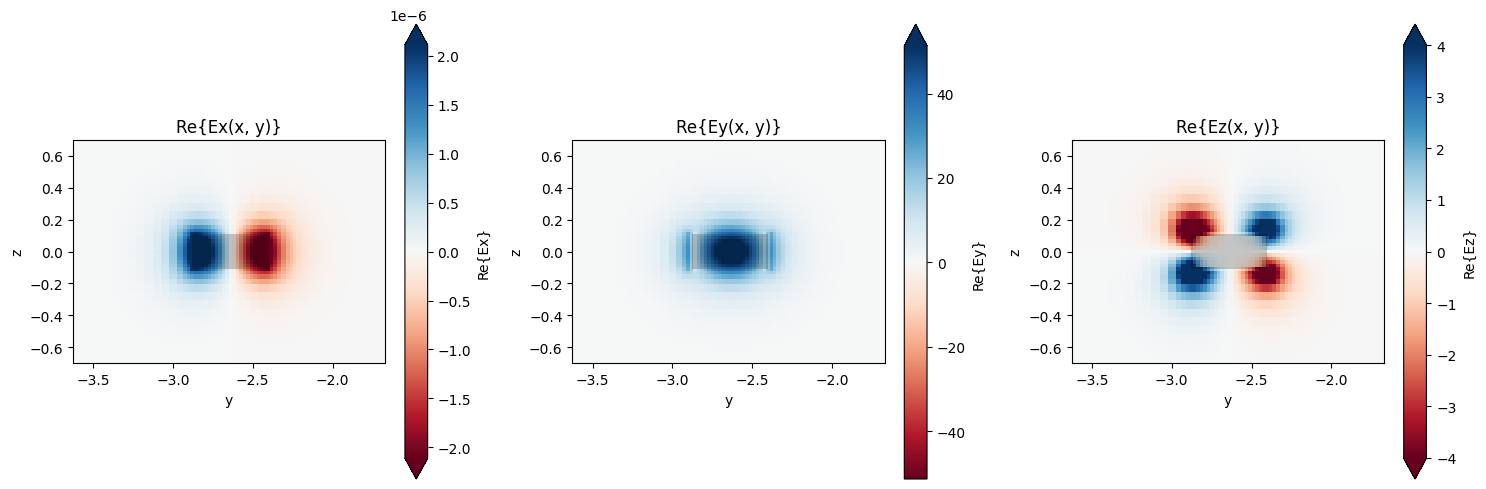

In [18]:
# visualise the mode
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5), tight_layout = True)
ms.plot_field("Ex", "real", f = freq0, mode_index = 0, ax = ax1)
ms.plot_field("Ey", "real", f = freq0, mode_index = 0, ax = ax2)
ms.plot_field("Ez", "real", f = freq0, mode_index = 0, ax = ax3)
ax1.set_title("Re{Ex(x, y)}")
ax2.set_title("Re{Ey(x, y)}")
ax3.set_title("Re{Ez(x, y)}")
plt.show()

# add mode source at the input of the waveguide
source_time = td.GaussianPulse(freq0 = freq0, fwidth = 0.5*freqw)
mode_source = ms.to_source(mode_index = 0, direction = "+", source_time = source_time)

sim = sim.copy(update = {"sources" : [mode_source]})

# Plot Simulation Setup

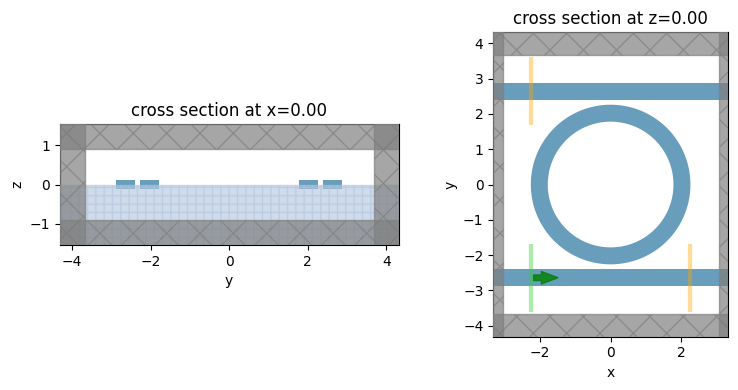

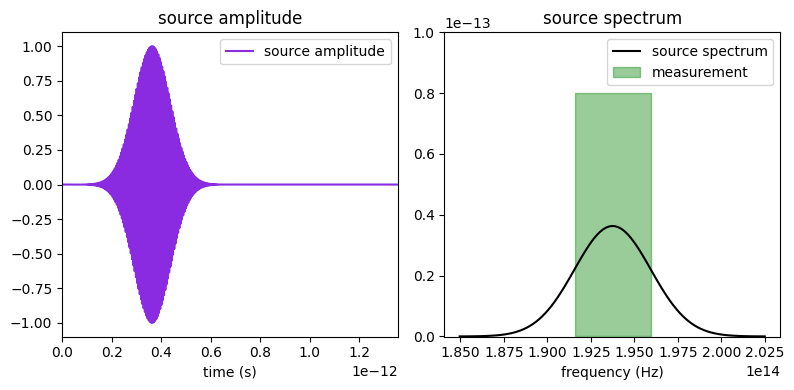

In [19]:
fig, ax = plt.subplots(1, 2, tight_layout = True, figsize = (8,4))
sim.plot(x = 0, ax = ax[0]);
sim.plot(z = 0, ax = ax[1]);
plt.show()

# Check probe and source
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
plot_time = run_time/40
ax1 = sim.sources[0].source_time.plot(times=np.linspace(0, plot_time, 10000), ax=ax1)
ax1.set_xlim(0, plot_time)
ax1.legend(('source amplitude',))
ax2 = sim.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim.run_time, 100000), val = 'abs', ax=ax2)
fill_max = 80e-15
ymax = 100e-15
ax2.fill_between(freq_range, [0,0], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

sim.plot_3d()



In [20]:
# initializes job, puts task on server (but doesnt run it)
job = web.Job(simulation=sim, task_name="single_ring_wg_480nm", verbose=True)

# estimate the maximum cost
estimated_cost = web.estimate_cost(job.task_id)

07:26:52 GMT Summer Time WARNING: Simulation has 1.36e+06 time steps. The       
                         'run_time' may be unnecessarily large, unless there are
                         very long-lived resonances.                            

07:26:53 GMT Summer Time Created task 'single_ring_wg_480nm' with task_id       
                         'fdve-0e49e686-1c18-49cb-831a-d009477cae1e' and        
                         task_type 'FDTD'.

                         View task using web UI at                              
                         ]8;id=421882;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e49e686-1c18-49cb-831a-d009477cae1e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=998367;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e49e686-1c18-49cb-831a-d009477cae1e\taskId]8;;\]8;id=421882;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e49e686-1c18-49cb-831a-d009477cae1e\=]8;;\]8;id=759730;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e49e686-1c18-49cb-831a-d009477cae1e\fdve]8;;\]8;id=421882;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e49e686-1c18-49cb-831a-d009477cae1e\-]8;;\
                         ]8;id=421882;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e49e686-1c18-49cb-831a-d009477cae1e\0e49e686-1c18-49cb-831a-d009477cae1e']8;;\.

Output()

07:26:56 GMT Summer Time Maximum FlexCredit cost: 1.491. Minimum cost depends on
                         task execution details. Use 'web.real_cost(task_id)' to
                         get the billed FlexCredit cost after a simulation run.

In [21]:
sim_data = job.run(path="data/microring_baseline.hdf5")

07:28:04 GMT Summer Time status = queued

                         To cancel the simulation, use 'web.abort(task_id)' or  
                         'web.delete(task_id)' or abort/delete the task in the  
                         web UI. Terminating the Python script will not stop the
                         job running on the cloud.

Output()

07:28:10 GMT Summer Time status = preprocess

07:28:13 GMT Summer Time Maximum FlexCredit cost: 1.491. Use                    
                         'web.real_cost(task_id)' to get the billed FlexCredit  
                         cost after a simulation run.

                         starting up solver

07:28:14 GMT Summer Time running solver

Output()

Output()

07:38:43 GMT Summer Time status = postprocess

07:38:44 GMT Summer Time status = success

                         View simulation result at                              
                         ]8;id=475396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e49e686-1c18-49cb-831a-d009477cae1e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=497759;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e49e686-1c18-49cb-831a-d009477cae1e\taskId]8;;\]8;id=475396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e49e686-1c18-49cb-831a-d009477cae1e\=]8;;\]8;id=720130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e49e686-1c18-49cb-831a-d009477cae1e\fdve]8;;\]8;id=475396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e49e686-1c18-49cb-831a-d009477cae1e\-]8;;\
                         ]8;id=475396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e49e686-1c18-49cb-831a-d009477cae1e\0e49e686-1c18-49cb-831a-d009477cae1e']8;;\.

Output()

07:38:47 GMT Summer Time loading simulation from data/microring_baseline.hdf5

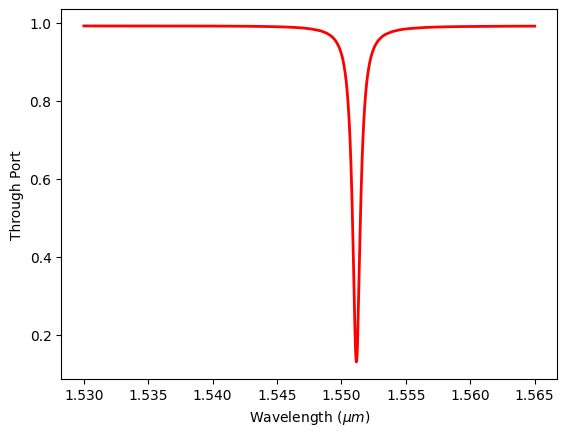

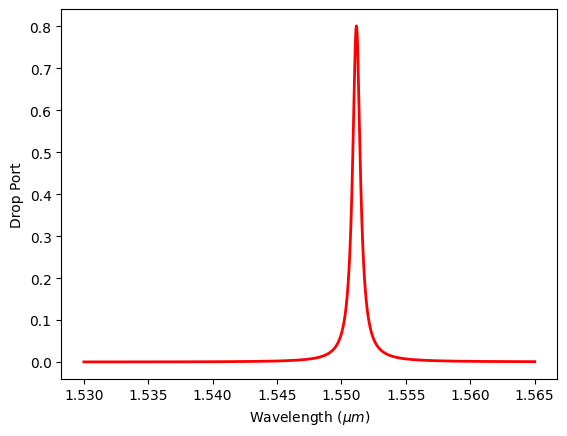

In [208]:
T1 = sim_data["Flux Monitor (Through Port)"].flux
T2 = sim_data["Flux Monitor (Drop Port)"].flux

measured_f = sim_data["Flux Monitor (Through Port)"].flux.f

plt.plot(td.C_0 / measured_f, T1, "red", linewidth=2)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Through Port")
plt.show()

plt.plot(td.C_0 / measured_f, T2, "red", linewidth=2)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Drop Port")
plt.show()
